# Instacart Market Basket Analysis
### Project Report by

## Introduction

The grocery industry is rapidly evolving as customers shift their shopping behavior toward online platforms. Instacart, a leading online grocery delivery service, provides an open dataset that captures real purchase behavior from thousands of customers. This dataset opens the door for sophisticated analysis and predictive modeling.

This project leverages machine learning techniques to build models which can assist in predicting customer behaviors to inform further business decisions.

 The goal is to understand a user’s shopping patterns, analyze product characteristics, model their interactions, and build an accurate predictive system. Our audience for this report includes prospective students in the Master of Science in Data Analytics (MSDA) program.

This project is split into two parts: Part A User Explorer, and Part B Product Recommender.

In Part A, our goal is to predict if an Instacart customer will buy _any_ new product in their next order, using their past shopping behavior. This prediction can help Instacart identify which customers are likely to trying something different. This can help with prioritizing ads on customers who are opening to buying new products.

In Part B, our goal is to predict the probability that a specifc user will purchase a specific profuct they have _never bought before_, in their next order. The application of this part is to generate a ranked list of personalized new product recommendations for each uses.



# Part A - User Explorer

## Exploratory Data Analysis

To begin, the Kaggle competition provided multiple datasets, which first load and will proceed to merge to create a target dataset.

The datasets are as follows:

1. orders.csv - The Order Log
*   **Purpose:** Contains metadata about each customer order. The central hub linking users to their order sequence.
*   **Key Columns:** `order_id`, `user_id`, `eval_set` (prior/train/test), `order_number`, `order_dow`, `order_hour_of_day`, `days_since_prior_order`.

2. `products.csv` - The Product Catalog
*   **Purpose:** Lists all unique products available.
*   **Key Columns:** `product_id`, `product_name`, `aisle_id`, `department_id`.

3. `order_products_prior.csv` & `order-products_train.csv` - Order Contents
*   **Purpose:** Detail exactly *which products* were in *which order*. Connects orders to products.
    *   `__prior.csv`: Contents of past orders (most history). Very large file.
    *   `__train.csv`: Contents of the specific 'train' orders used for defining our target.
*   **Key Columns:** `order_id`, `product_id`, `add_to_cart_order`, `reordered` (1 if bought previously by user, 0 if first time).

Inspecting the reordered item distributuion in the prior orders, we see calculate the following


In [ ]:
# Output from Notebook analysis:
# Value Counts for 'reordered':
# reordered
# 1    0.589697  (~59.0%)
# 0    0.410303  (~41.0%)
# Name: proportion, dtype: float64

This shows about 59% of te items purchased in the historical dataset were items the users had bought before. 41% were first-time purchases.

4. `aisles.csv` & `departments.csv` - Category Lookups
*   **Purpose:** Translate `aisle_id` and `department_id` into human-readable names.
*   **Columns:** `aisle_id`, `aisle` (name); `department_id`, `department` (name).



## Target Creation


Our goal is to predict if a cutstomer will purchase a new product. There is no explicit dataset detailing this interaction, but we can merge the given datasets to create this target.

We define our target variable using the `'eval_set'` column in `orders.csv`:
1.  We identify orders marked as `'train'`. These represent the "next order" for a subset of users.
2.  We look at the products purchased in these `'train'` orders (using `order_products__train.csv`).
3.  We compare these products to the customer's *entire* purchase history from *all* their orders marked as `'prior'` (using `orders.csv` and `order_products__prior.csv`).

**Target Variable (`new_product_purchased`):**
*   **1 (Yes):** If the customer's `'train'` order contains at least one product they had **never** purchased in *any* of their `'prior'` orders.
*   **0 (No):** If *all* products in the customer's `'train'` order were products they had purchased at least once in their `'prior'` orders.

This binary variable (0 or 1) will be what our machine learning model tries to predict.

We then code a table which contains two columns: userId and new_product_purchased.

In [ ]:
# Output from Notebook:
# new_product_purchased
# 1    0.815554  (~81.6%)
# 0    0.184446  (~18.4%)

The results showed that over 80% of all users purchased a new product in their most recent Instacart order.

## Feature Engineering


With our new target variable created, we then needed to create the varaibles we would use to predict this target. These are calculated from the users prior order history and can summarize their typical shopping habits.

 It is important to note that because of the imbalance noted earlier, where 80% of the shoppers purchased a new item, this means that most of the users in our database do explore new products. What this means is that if we built a model which does nothing and just guesses that each user would buy a new product, we would immediately be correct 80% of the time.

 In this case, we instead aim to correctly identify if a user will _not_ purchase a new product. We will refer to this case as class 0. This flips our objective to prediction with the goal of identifying which customers we will _not_ prioritize advertising to.

 As initial variables, we create

1.  `user_total_orders`: Total number of prior orders placed. (Indicates experience/history length).
2.  `user_avg_days_since_prior`: Average number of days between prior orders. (Indicates typical purchase frequency).
3.  `user_avg_basket_size`: Average number of items purchased per prior order. (Indicates typical order size).
4.  `user_reorder_ratio`: Overall proportion of items purchased across all prior orders that were reorders. (Indicates tendency to stick to known items vs. explore).


## Prepare for Data Modeling


Now that we have the target variable and the additional variables (or _features_), we merge the two into single table, matching each row by the userID column. Then we split the data into a training and test set.

It's important to split the data this way so that when we are training our model, it's not being tested on the same data it was trained on. That would lead to the model simply memorizing this specific instance of data and it would be unable to accurately predict on data it had not seen before.

We also stratify the data into a ratio of 1s and 0s to ensure that both the training and test set maintain the same proportion of users who do purchase a new product and users who do not.

## Building and Evaluating a Baseline Model


The first model we build uses the Logistic Regression mehtod. This method learns a linear relationship between the variables and what's called the _log-odds_ of the target variable. The _log-odds_ are then transformed into a probability between 0 and 1, where if the value is less than 0.50, we predict a 0, otherwise we predict a 1.

We start here because this model is computationally efficicent and relatively easy to interpret, so it serves as a baseline performance model.

To evaluate the model, we will print out the results of the model statistics once it's predicted on the test set. We will then compare the predicted results to the real results. The metrics we will use are:
*   **Precision:** Of all the times the model predicted class 0, how often was it right? (High precision means few False Positives).
*   **Recall:** Of all the actual instances of class 0, how many did the model correctly identify? (High recall means few False Negatives).
*   **F1-Score:** A single score that balances both Precision and Recall.
*   **AUC (Area Under the ROC Curve):** Measures how well the model can distinguish between the 1s and 0s. It ranges from 0.50, which amounts to random guessing, and 1.0, which would be a perfect separation.
*   **Confusion Matrix:** A table showing the counts of:
    *   True Negatives (Actual 0, Predicted 0)
    *   False Positives (Actual 0, Predicted 1)
    *   False Negatives (Actual 1, Predicted 0)
    *   True Positives (Actual 1, Predicted 1)


## Logistic Regression Evaluation Metrics


| AUC-ROC | Precision | Recall | F1-Score |
|---------|-----------|--------|----------|
| 0.7523  | 0.67      | 0.16   | 0.26     |

Analysis of Logistic Regression Results -
The baseline logistic regression shows a high overall score of 0.75, which shows the model can differentiate between users who will buy a new product and those who don't 3 out of 4 times. However, the Recall is very low, at 0.16.

 This means that we have a lot of false negatives predicted with this model, and we are predicting users _will_ purchase a new product, when in reality they don't. Our precision is 0.67, meaning when this model _does_ predict a user will not purchase a new product, we are correct two-thirds of the time.

 The resulting F1-Score is very low, highlighting the model's difficulty predicting class 0.

## Trying a More Complex Model: Random Forest

As logistic regression assumes a linear relationship between the variables, it may not perform well if the actual relationships are non-linear, as real world behavior is often more complex.

In this case, we can try using Random Forest, a tree based method which is more suited for
* Handling Non-Lineararity
* Capturing Interactions Between Variables
* Being Robust Against Outliers
* Handling Imbalances

Using this model, we can include a flag to pay more attention to getting the class 0 predictions correct, even if it means slightly more errors on class 1 predictions. We include this flag to make up for the imbalance in data, as there are over 80% class 1 instances and less than 20% class 0 instances.

## Random Forest Evaluation Metrics


| AUC-ROC | Precision | Recall | F1-Score |
|---------|-----------|--------|----------|
| 0.7031  | 0.48      | 0.23   | 0.31     |

Analysis of Random Forest Results -

This model slightly increases the overall F1-Score and our Recall slightly improves compared to Logistic Regression, but the model's overall performance in it's AUC decreases.

Note the bar chart of our resulting Feature Importances shows that the most important variable is the `user_reorder_ratio`, then `user_avg_basket_size`, `user_avg_days_since_prior`, and `user_total_orders`.


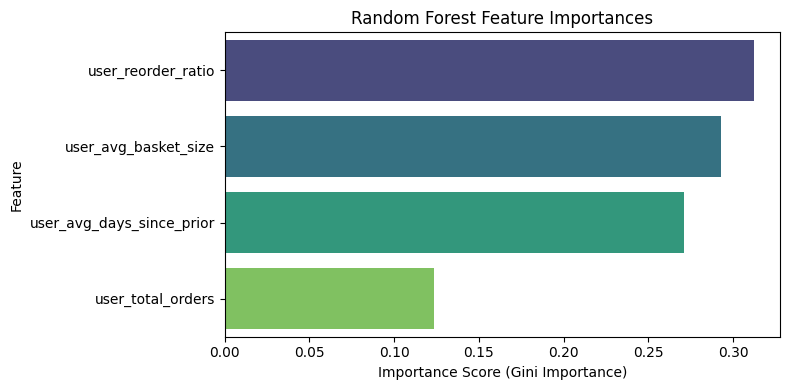

While Random Forest addressed the specific goal of improving class 0 recall, the drop in overall discriminatory power (AUC) is concerning. It suggests that simply applying a standard non-linear model with basic flagging wasn't sufficient with our current features.



## Trying Another Advanced Model: XGBoost



Random Forest didn't significantly improve on Evaluation Metrics compared to Logistic Regression, so we'll try one more non-linear tree model. In this case, XGBoost differs from Random Forest in that it builds it's trees sequentially and uses built-in regularization techniques. Together, these help increase model accuracy. XGBoost also includes a method for handling imbalance in dataset, as Random Forest did.

## XGBoost Evaluation Metrics

| AUC-ROC | Precision | Recall | F1-Score |
|---------|-----------|--------|----------|
| 0.7483  | 0.35      | 0.64   | 0.45     |

Analysis of XGBoost Results -
XGBoost achieved the highest recall for class 0 our three models, at 0.64. It also has the highest F1-Score, while having a AUC score close only slightly lower than Logistic Regression attained.

For a full review of the compared model metrics, you can see the following table.

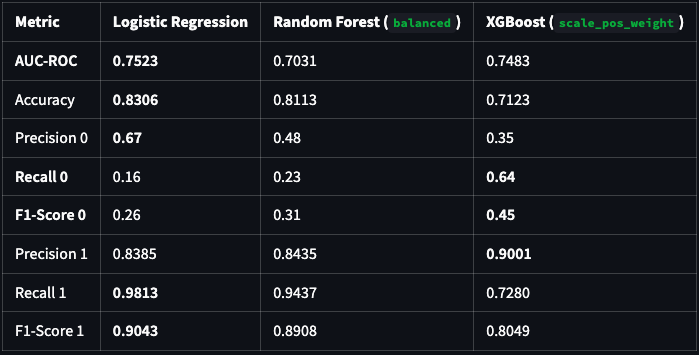

Additionally, we note the feature importances of the XGBoost model, where the variables are still in the same order of importance, but the magnitude of importance of `user_reorder_ratio` and `user_avg_basket_size` are much larger.

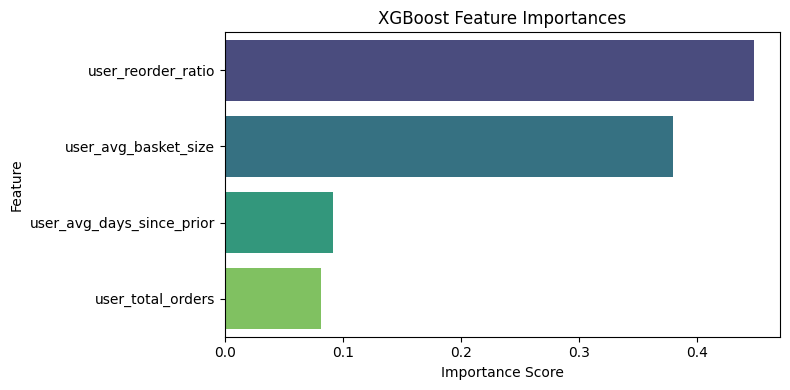

Overall, none of the models is outright superior than another. Logistic Regression actually offers the best AUC and balanced performance _for class 1_ and is easily interpretable, but XGBoost provides the best performance for identifying class 0. However, since it nor Random Forest were able to surpass the baseline Logistic Regression despite their higher complexity suggests that we may be limited by our current set of only four variables.

## More Feature Engineering


We proceed by deriving a handful of new variables from the given datasets to add to our table.

1.  **User Timing Patterns:** Look more closely at *when* users shop.
    *   `user_median_days_since_prior`: Median days between orders (more robust to outliers than the average).
    *   `user_std_days_since_prior`: Standard deviation of days between orders (measures consistency of timing).
    *   `user_most_frequent_dow`: Most common day of the week for orders.
    *   `user_most_frequent_hour`: Most common hour of the day for orders.
2.  **User Product Diversity:** Measure the variety of products purchased.
    *   `user_total_departments`: Number of distinct departments purchased from.
    *   `user_total_aisles`: Number of distinct aisles purchased from.
    *   `user_avg_unique_prods_per_order`: Average number of *unique* products per order basket.
3.  **User Reorder Details:** Add more context to reordering.
    *   `user_total_items_purchased`: Total number of items (lines in order_products) across all prior orders.
    *   `user_reorder_sum`: Total count of items flagged as 'reordered' across all prior orders.

Once we merge these new variables to our dataset, we split and stratify once more. Next, we build and evaluate our models a second time. The resulting chart details our new evaluation metrics compared to our initial models.


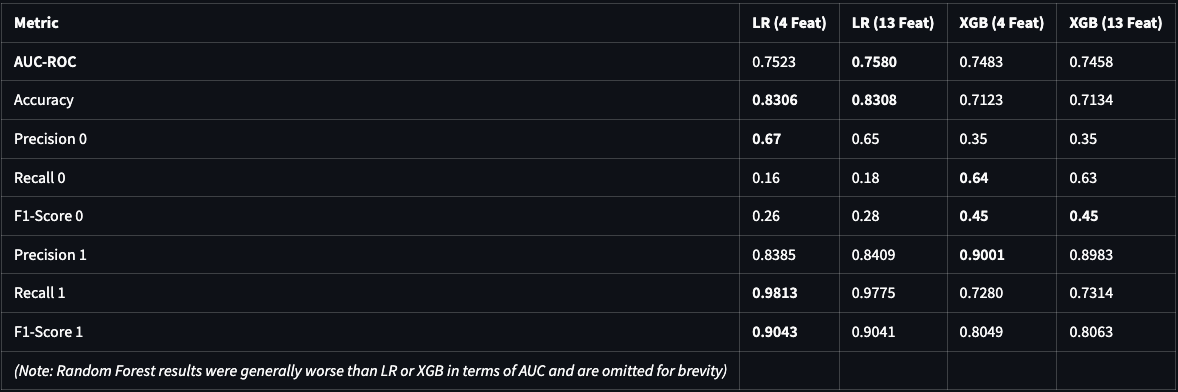

Compared to our initial results, our models with additional variables result in no significant improvement. In fact, there is very slight decrease in performance for our XGBoost model.

Taking a look at the feature importances chart for our second XGBoost model, we notice that the two most important variables, and still by a wide margin, remain the same. However, we do see `user_total_departments` and `user_total_aisles` emerge as our next two important variables.

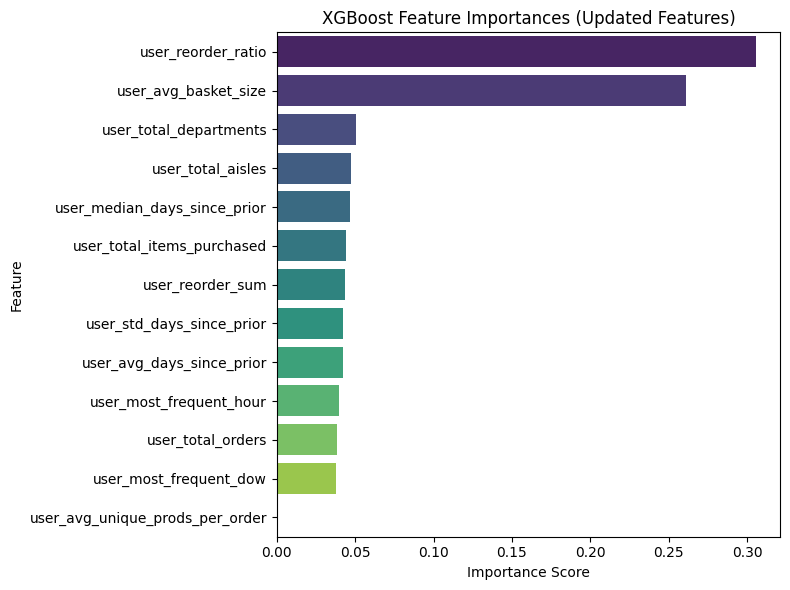

## Hyperparameter Tuning and Threshold Adjustment


To proceed, we will optimize XGBoost as it was our model which excelled in predicting class 0 with the highest accuracy whilst balancing it's class 1  prediction accuracy.

We do this by adjusting the _hyperparameters_, or the settings of the machine learining algorithm.

**Why Tune Them?**
Default hyperparameter values are often not optimal for a specific dataset. Finding the right combination can significantly impact model performance, potentially leading to better accuracy, AUC, or a better balance between precision and recall.

**Our Approach:**
We will use an algorithm called `RandomizedSearchCV`, which samples a fixed number of parameter combinations. It's often more efficient for exploring a wide range of possibilities.


Similar to how the default hyperparameters of XGBoost is not optimal, the default threshold of 0.5, where all calculations that result in less than 0.5 are classified as 0 and all above are classified as 1, is not optimal.

We can generate a graph of the model metrics, where the intersection point is our optimal threshold.


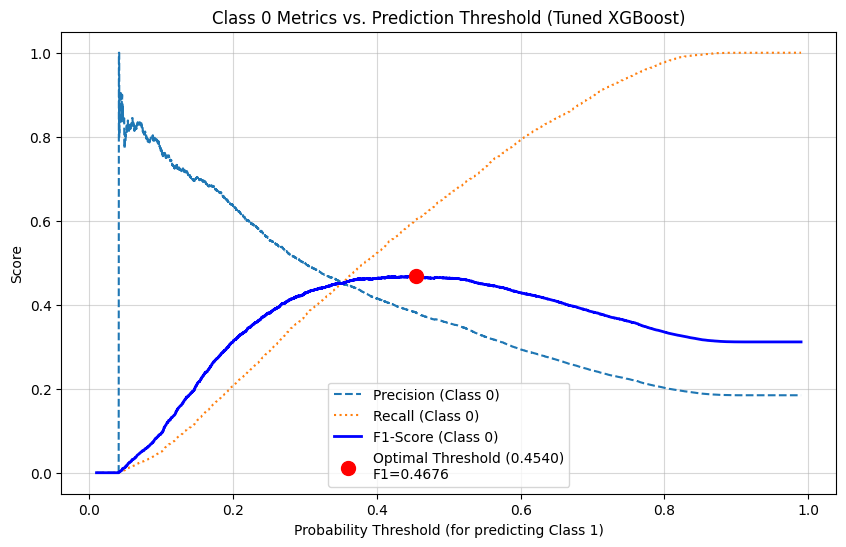

However, what we discover is that the optimal threshold is 0.454, which returns practically the same results as our earlier models.

## Even More Feature Engineering

Not quite convinced our model can't be further improved, we brainstorm even more variables. We consider the possibility that a user's historical data might not accurately represent their most recent behaviors and current state of mind.

In this case, we create the `days_since_last_order` and `last_order_basket_size` variable.

The variales are merged into our table, then we split and stratify the data once more before training the XGBoost model a final time.

## Final XGBoost Model Evaluation Metrics

| AUC-ROC | Precision | Recall | F1-Score |
|---------|-----------|--------|----------|
| 0.7803  | 0.36      | 0.70   | 0.48     |

Our final model is the most superior in evaluation metrics. Althought the model only correctly predicts no purchase a third of the time, when it does predict no purchase, it is correct 70% of the time.

What we find is that there is a trade-off between the precision and recall metric when identifying class 0, probably because of the small ratio of class 0 instances in the dataset. If we were to priortize minimizing false positives, we would use  our Logisitic Regression model. If we were to prioritize minimizing false negatives, we would use this XGBoost model.

Furthermore, the resulting feature importances charts show our top variable is now `last_order_basket_size`, dethroning `user_avg_basket_size_` as our most significant variable.

This goes to show that a lot of the machine learning process depends on the variables we can derive from our dataset, not just running an algorithm on a table. Although we are content with the results of this final model, it is entirely reasonable to assume higher performance could be pulled from the model if we continue with brainstorming ways to combine the given data to create a new variable that highlights a relationship between the users and the products.



# Localhost Demo - User Explorer

Since we had trouble with getting the large datasets and models to load on our Streamlit deployment, a short demo of the interactive models can be viewed in the following video: https://youtu.be/yk3aZmSPJbY

In this video, we use a random number generator to get a random userID. Then, we run the ID in our User Explorer to see the probability of this user purchasing a new product.

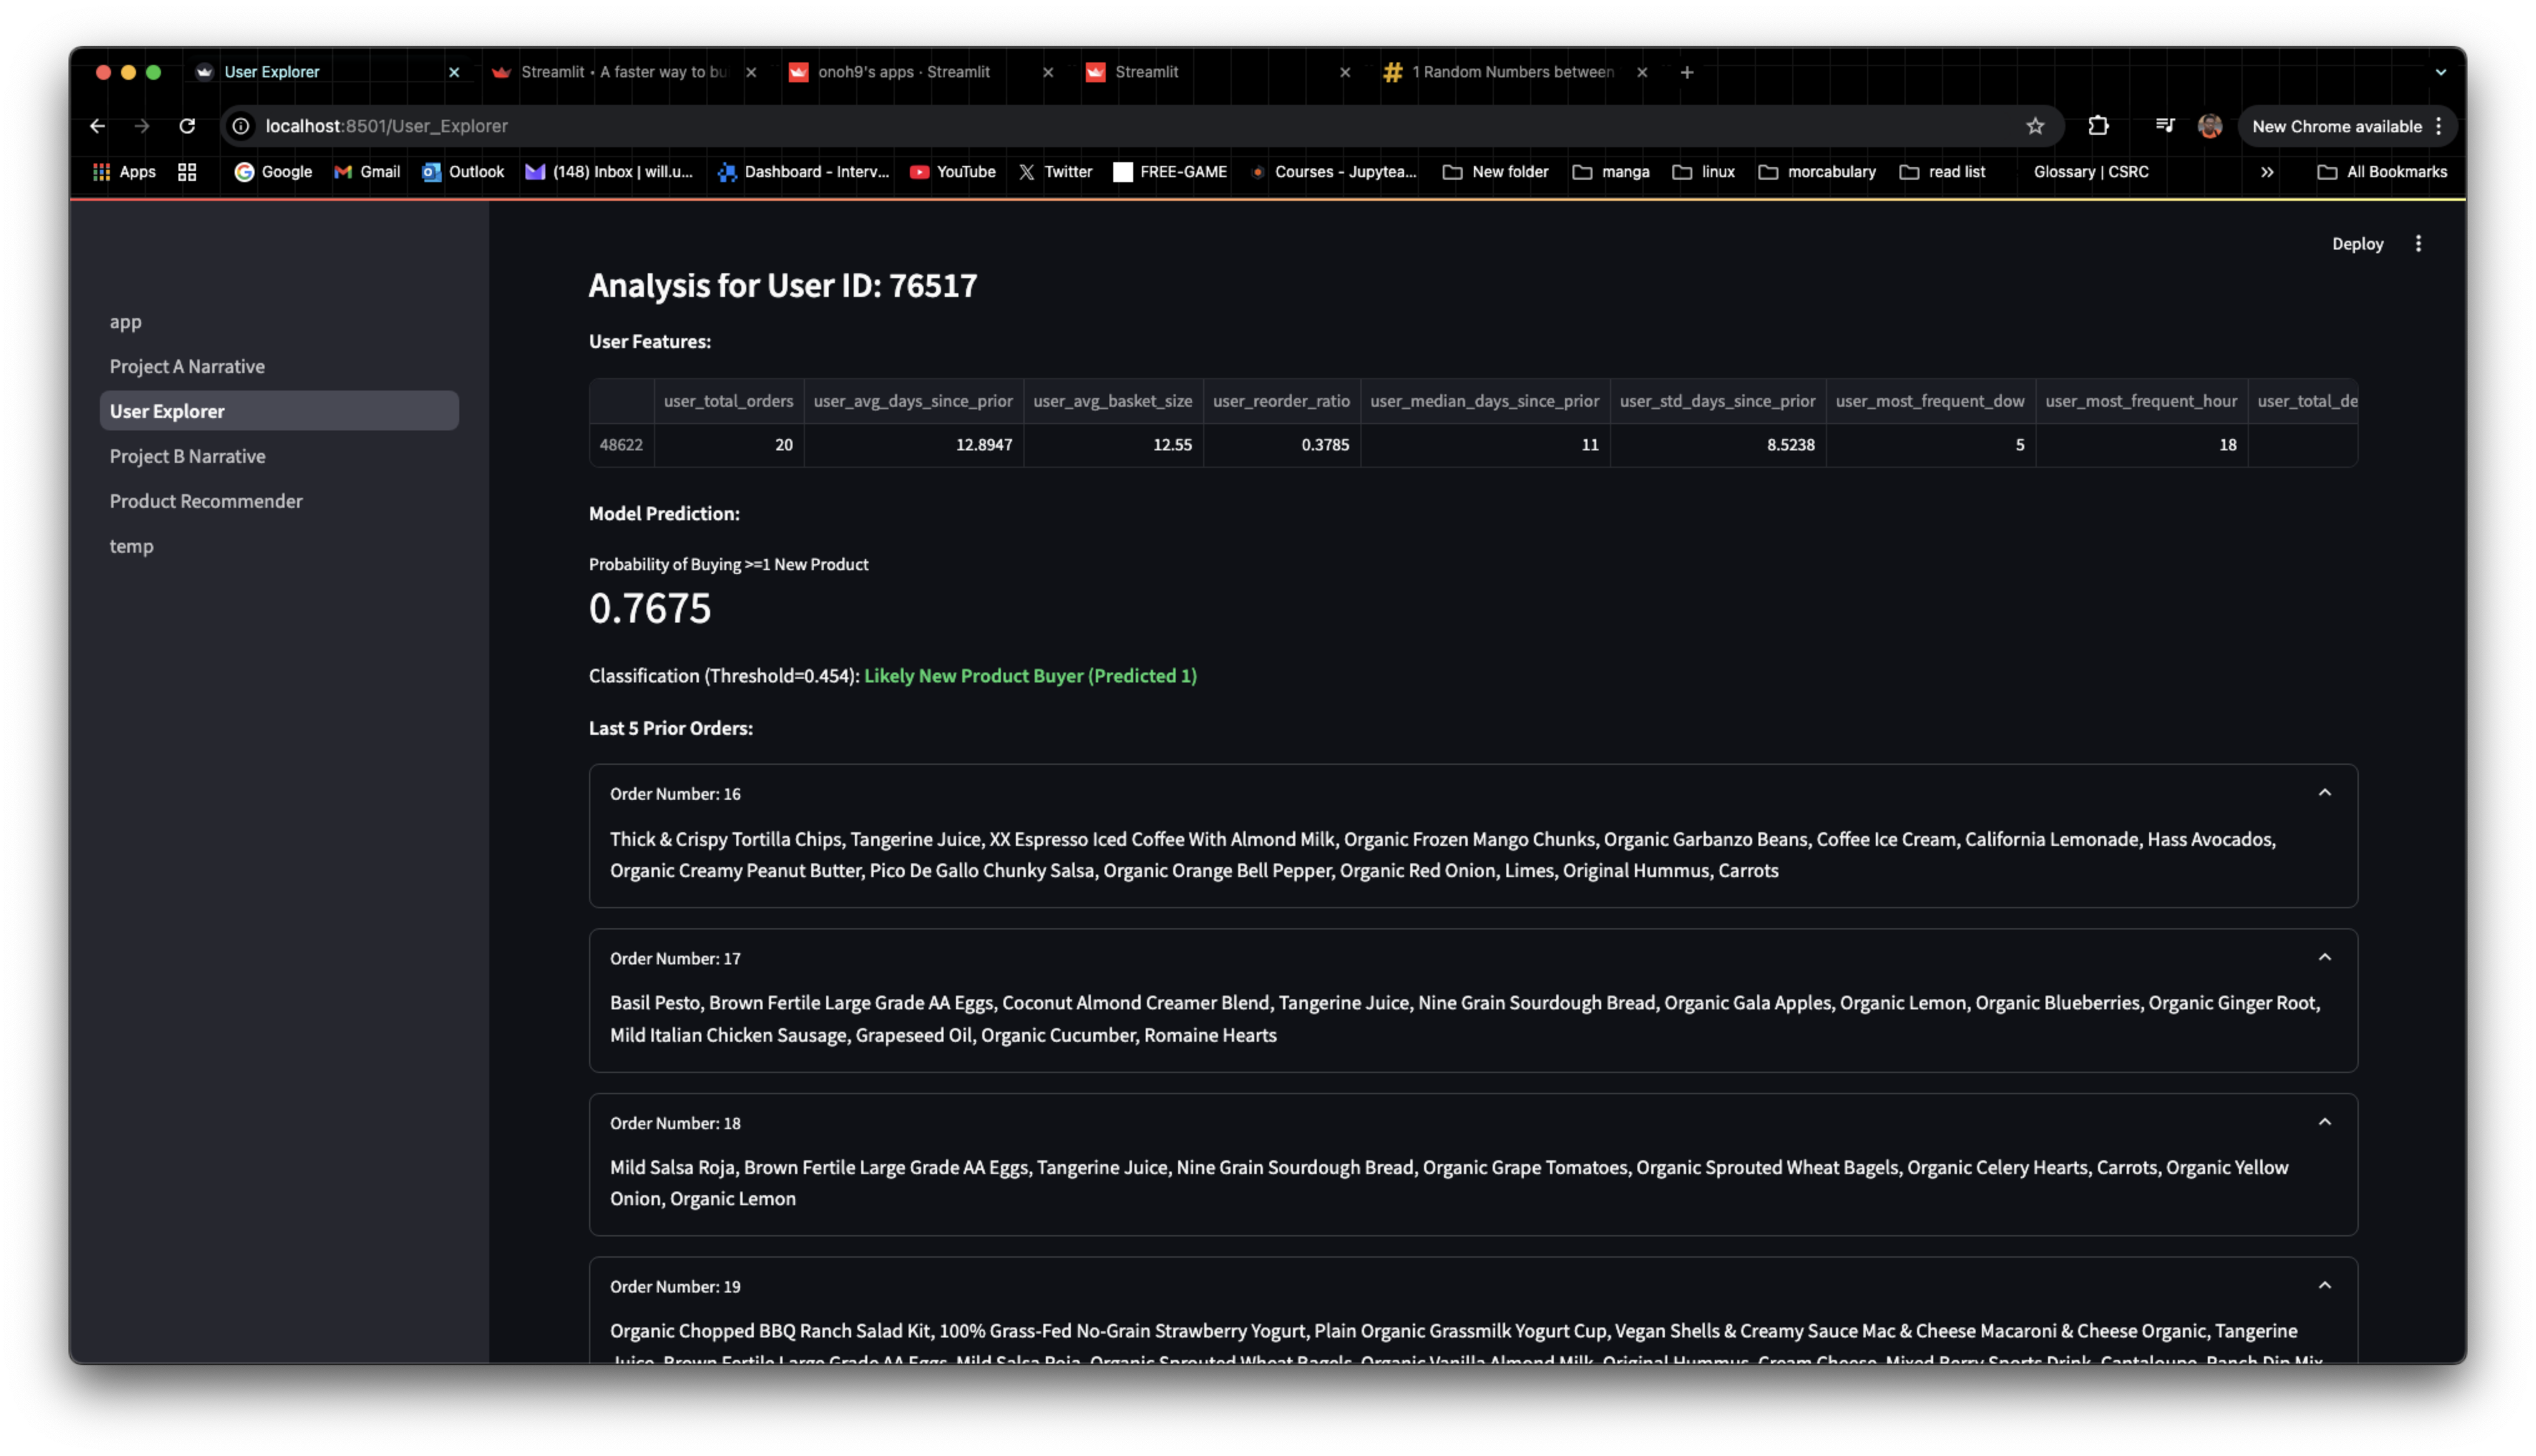

# Part B - Product Recommender

The goal of the next part of our project is to predict the probability that a specific user will purchase a specific product they have never bought before in their next order. The application is to generate a ranked list of personalized new product recommendations for each user.

## Data Generation & Sampling

Our goal is to create a dataset where each row represents a potential purchase of a specific product by a specific user in their 'train' order, labeled with whether that purchase actually happened (target=1) or not (target=0). We only consider products the user had never bought before.



## Feature Engineering

Next, we create features to predict on. We brainstorm three categories of variables and extrapolate from there.
1.  **User Features:** General purchasing habits
    *   Examples: a user's total number of orders, average days since a user's prior order, a user's average basket size, etc.
2.  **Product Features:** Characteristics of the product itself based on overall purchasing data.
    *   Examples: how many times a product has been purchased across all orders (popularity), the average position a product has across all orders, i.e., first item in the basket or fifth item in the basket
3.  **User-Product Interaction Features:** Features capturing the specific historical relationship.
    *   Examples: how many times a user has bought a specific product,  across all orders, how many consecutive orders a product appears in a users basket.


Once again, we derive our variables and merge them into a table before splitting and stratifying the table before training our model.

## Model Training and Evaluation

For our model, we choose LightGBM. This is another gradient boosting model like XGBoost, but is known for being significantly faster and often more memory efficient on large datasets.

Again, we evaluate the model on it's class 0 performance, that is, how well it can identify the cases where a user _does not_ purchase a product. The reasoning here is that it is more useful to a company to know which users to _not_ target in the context of saving on advertising.

In the baseline build of of LightGBM model, we achieve the following metrics

| AUC-ROC | Precision | Recall | F1-Score |
|---------|-----------|--------|----------|
| 0.9166  | 0.96      | 0.84   | 0.60     |

The resulting scores are very high. Our model is correct 96% of the time it preducts no new purchase, and can identify 84% of all the instances when a new product is not purchased.

As a principle, we proceed in in trying to improve our model by brainstorming new features like 'how many times a user has bought _any_ product from a specific aisle. We also continue with hyperparameter tuning, using RandomizedSearch again to determine the optimal hyperparameters. The resulting metrics are the same, except the recall improves slightly to 85%.

In the following Feature Importances chart of our LightGBM model, we notice that the 'product purchase count' variable, how many times a specific product had been purchased across all users' orders, was by far the most significant variable. The next two significant in predicting if a user would purchase a new product for the first time were how many times a user has bought any product from a specific product's aisle, and the rate that which across all orders a product appears beyond it's first appearance.

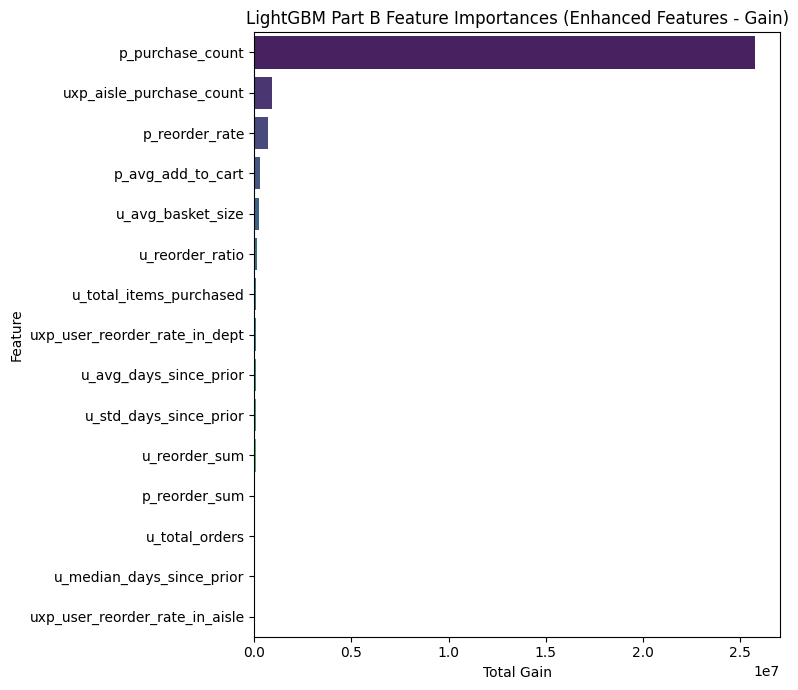

# Localhost Demo - Product Recommender

Since we had trouble with getting the large datasets and models to load on our Streamlit deployment, a short demo of the interactive models can be viewed in the following video: https://youtu.be/yk3aZmSPJbY

In this video, we use a random number generator to get a random userID. Then we run this ID in the Product Recommender to see the top products the user is likely to purchase for the first time and the least likely products to be purchased for the first time.

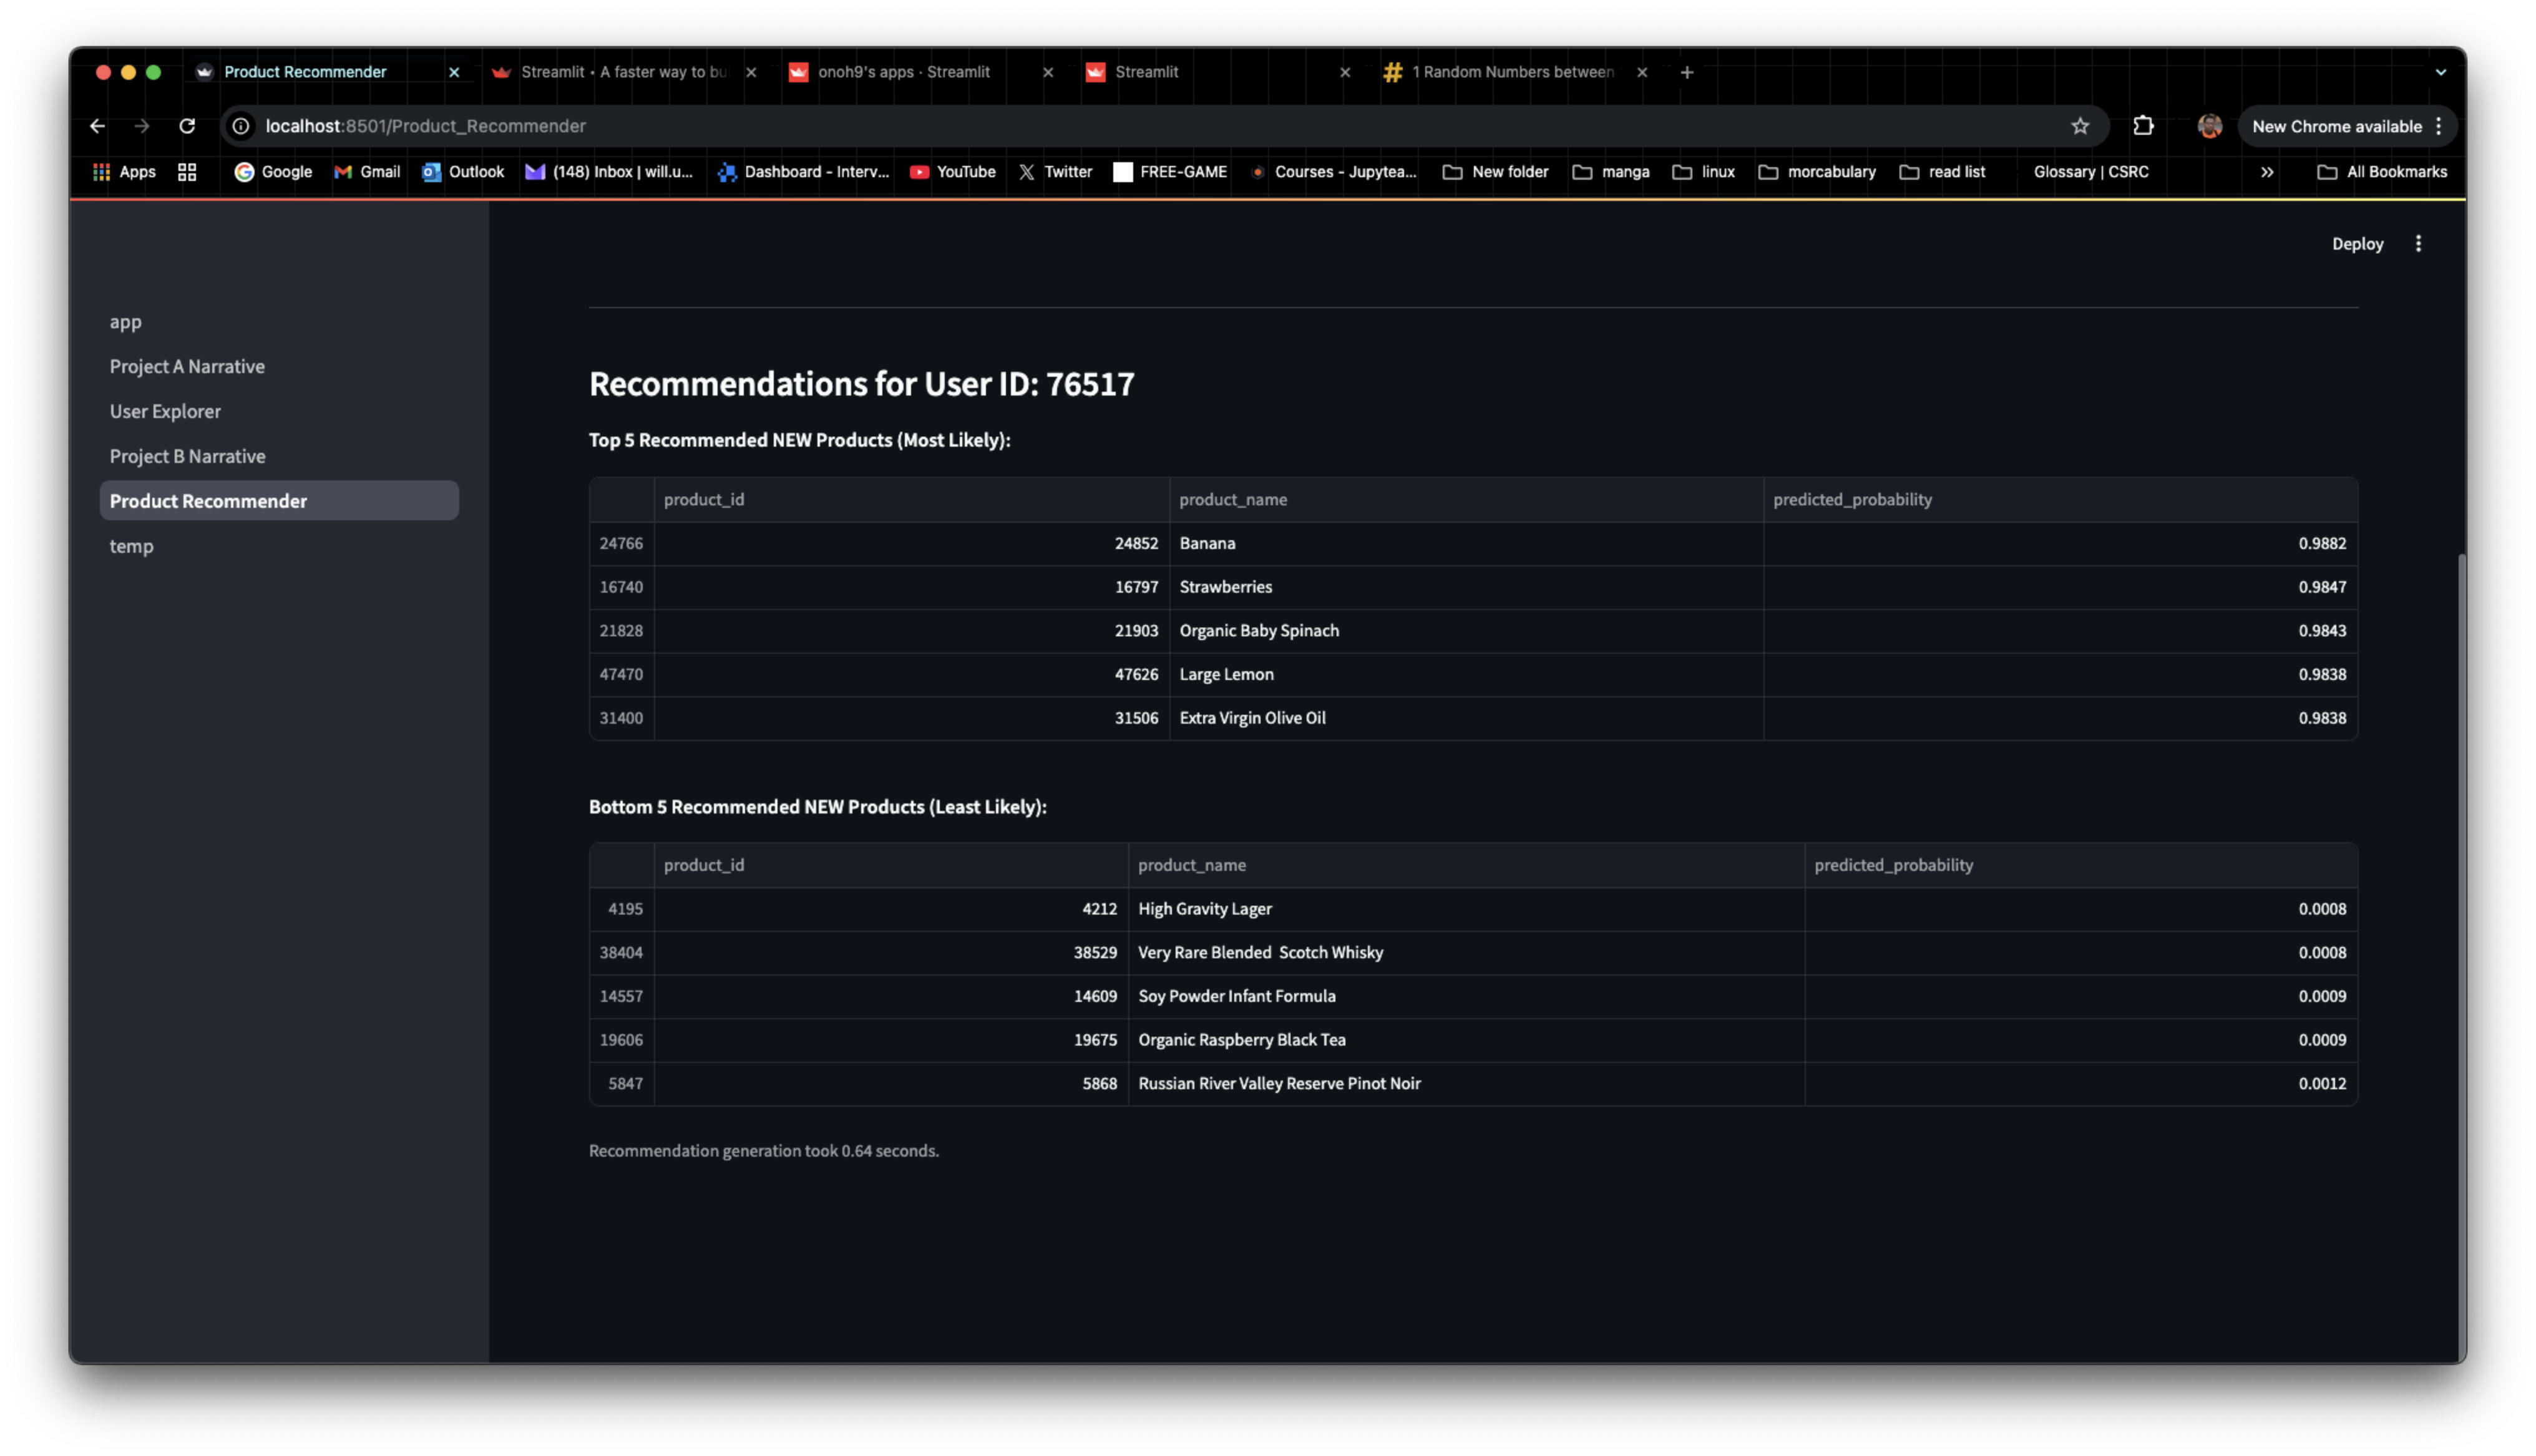

# Compartive Analysis and Conclusion

We developed two models addressing related but different questions using the Instacart data:

*   **Part A Model:** Predicts if a user will buy *any* new product. Goal: Identify explorer vs. habitual users.
*   **Part B Model :** Predicts if a user will buy a *specific* new product. Goal: Rank potential new products for recommendation.


Let's compare the insights derived from each:

**1. Feature Importance Contrast:**

*   **Part A (User-Level Prediction):**
    *   Dominated by **User Aggregate Features**, primarily `user_reorder_ratio`.
    *   Recency features (`last_order_basket_size`, `days_since_last_order`) were also highly important, indicating the last order strongly influences the *next* order's overall exploratory nature.
    *   Average user stats (`u_avg_basket_size`) played a secondary role.
*   **Part B (User-Product Level Prediction):**
    *   Dominated by **Product Features**, especially `p_purchase_count` (product popularity). Popular products are simply more likely to be tried as a first purchase.
    *   **Interaction Features** were highly significant (`uxp_aisle_purchase_count` was #2). Knowing the user's history with the product's *category* is crucial.
    *   **User Aggregate Features** (`u_avg_basket_size`, `u_reorder_ratio`) still contribute significantly but are less dominant than in Part A, indicating that *who the user is* matters, but *what the product is* and the *user-category fit* matters more for specific product prediction.


Comparing the models, the significantly higher score in Part B (0.92 vs 0.78) suggests that predicting whether a *specific* popular product will be bought (even by a new user) is an easier task than predicting the *general exploratory tendency* of a user across their entire next basket. Product popularity itself provides a strong baseline.

**Conclusion:** This project combined all major phases of a real-world machine learning pipeline: data wrangling, exploratory analysis, advanced feature engineering, model development, evaluation, and deployment planning. It reinforced our understanding of relational data, class imbalance, tree-based models, and recommender system metrics.

From a business perspective, predicting which new product a user might try has strong implications. It enables:

  * More personalized and engaging shopping experiences

  * Improved customer retention through surprise-and-delight strategies

  * Targeted promotions and marketing efficiency

For future work, we could:

  * Extend the model to include user demographics or session-level behavior

  * Experiment with deep learning-based recommender systems (e.g., neural collaborative filtering)

  * Build the full Streamlit app and conduct A/B testing on recommendations



In summary, this project is a strong demonstration of applied machine learning in a retail context, showcasing the value of combining structured data with thoughtful modeling. We hope it serves as both a practical guide and an inspiring use case for future MSDA students.

